### Goal: Beat Andy and Emmanuel for ESL One Cologne fantasy league

I'd like to simulate the matchups across the tournament to determine a teams likilhood of winning the tournament. I having the most likely played out bracket, I will look at team matchups and see historically how players have performed in those matchups and also weight their performance against recent historicals for a team on a particular map. Essentially will choose the players that are predicted to perform the best (ADR-wise?) across the entire tourny.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from os.path import join

import matplotlib.style as style
style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Team Level Analysis

In [6]:
team_path = '../data/master_team'
team_files = listdir(team_path)

# Import data
team_df = pd.DataFrame()
for file in team_files:
    file_df = pd.read_csv(os.path.join(team_path, file))
    team_df = team_df.append(file_df, ignore_index=True, sort=False)

# Order Columns
team_df = team_df[['date_human_utc', 'event_name', 'event_id', 'map', 'map_id',
                   'team_name', 'team_id',
                   'team_kills', 'team_assists', 'team_deaths', 'team_score']]
print('Shape before drop:', team_df.shape)

# Drop rows where there are NaN values for kills, assists, and deaths
team_df = team_df.loc[-team_df['team_kills'].isna(), :]


# Change datatypes
columns = ['event_id', 'map_id', 'team_id', 'team_kills', 'team_assists', 'team_deaths', 'team_score']
for column in columns:
    team_df[column] = team_df[column].astype(int)
    
print('Shape after drop:', team_df.shape)
team_df.tail()

Shape before drop: (132026, 11)
Shape after drop: (131974, 11)


,date_human_utc,event_name,event_id,map,map_id,team_name,team_id,team_kills,team_assists,team_deaths,team_score
132021,2019-06-30 13:00:00,Kalashnikov Cup Season 2,4463,mrg,88632,Nemiga,7969,75,16,104,13
132022,2019-06-30 12:40:00,GEXCon 2019 - NCS Major,4705,d2,88633,The Home of the Grave,10179,90,17,102,11
132023,2019-06-30 14:00:00,Good Game League 2019 Closed Qualifier,4703,trn,88634,NoChance,9722,93,17,103,13
132024,2019-06-30 14:05:00,LOOT.BET Smack My Beach Cup,4684,mrg,88635,BLUEJAYS,5347,89,13,79,16
132025,2019-06-30 13:00:00,Kalashnikov Cup Season 2,4463,nuke,88636,Nemiga,7969,107,21,87,16


I am only going to consider historicals for teams from 2018 up to present.

In [7]:
team_df = team_df.loc[team_df['date_human_utc'] >= '2018-01-01 00:00:00', :]
team_df.reset_index(drop=True, inplace=True)
print(team_df.shape)
team_df.head()

(51220, 11)


,date_human_utc,event_name,event_id,map,map_id,team_name,team_id,team_kills,team_assists,team_deaths,team_score
0,2018-01-04 07:15:00,Letou Invitational,3468,inf,59512,ViCi,7606,94,20,63,16
1,2018-01-04 08:30:00,Letou Invitational,3468,cch,59513,New4,4865,79,16,41,16
2,2018-01-04 11:00:00,Letou Invitational,3468,ovp,59514,MVP PK,7354,95,20,110,12
3,2018-01-04 17:30:00,ASUS ROG JTR Community Challenge Grand Finals ...,3488,mrg,59515,ROG friberg,8697,147,17,145,20
4,2018-01-04 18:05:00,ESEA MDL Season 26 Europe Finals,3365,mrg,59518,eXtatus,6745,107,26,110,14


In [8]:
print('Number of teams:', len(team_df['team_id'].value_counts()))
print('Number of maps:', len(team_df['map_id'].value_counts()))

Number of teams: 1889
Number of maps: 25610


### Player Level Analysis

In [10]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2018-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(256090, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
256085,79917,inf,2018-12-30,6503,CyberZen,180,Savage,12,8,5,0,17,77.3,-5,73.5,-3,0.98,0.55,0.77,0.66
256086,79918,mrg,2018-12-30,6503,CyberZen,839,tb,14,7,3,1,16,65.4,-2,65.7,-2,0.88,0.54,0.62,0.59
256087,79919,d2,2018-12-30,6503,CyberZen,839,tb,8,3,4,1,11,85.7,-3,43.3,-3,0.82,0.38,0.52,0.28
256088,79920,inf,2018-12-30,6503,CyberZen,7016,HZ,14,7,3,0,18,64.3,-4,50.9,-2,0.78,0.50,0.64,0.66
256089,79921,mrg,2018-12-30,6503,CyberZen,10168,bottle,10,5,4,1,9,77.8,1,59.7,1,1.13,0.56,0.50,0.92


To rank player performance I will consider how a particular player has played most recently and also consider how a player has matched up against a particular opponent.

Exponential Decay:
- y = a(1 - r)^x
- a = initial value (the amount before measuring growth or decay)
- r = growth or decay rate (most often represented as a percentage and expressed as a decimal)
- x = number of time intervals that have passed

#### Feature Engineering

In [11]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
0,79922,inf,2019-01-04,8248,PACT,16847,mhL,18,9,1,0,16,63.0,2,74.5,4,1.14,0.67,0.59,1.41,177.0,0.004556,0.020712
1,79923,mrg,2019-01-04,8248,PACT,16847,mhL,19,12,4,0,17,64.0,2,79.6,-2,1.08,0.76,0.68,1.05,177.0,0.004556,0.020712
2,79924,d2,2019-01-04,7535,ROG SPUNJ,11789,Misfit,15,6,3,1,17,58.3,-2,70.1,0,0.94,0.62,0.71,0.99,177.0,0.004556,0.324556
3,79925,mrg,2019-01-04,9791,ROG pronax,17082,Ex6poN,21,9,1,0,19,65.4,2,71.0,0,1.09,0.81,0.73,1.30,177.0,0.004556,0.244233
4,79926,cch,2019-01-04,8695,ROG nooky,18457,s1las,20,11,5,0,20,79.2,0,91.4,1,1.17,0.83,0.83,1.10,177.0,0.004556,0.162479


In [41]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR
0,79922,inf,8248,PACT,16847,mhL,0.372815,0.020712,0.331391,1.543040
1,79923,mrg,8248,PACT,16847,mhL,0.393527,0.082848,0.352103,1.648671
2,79924,d2,7535,ROG SPUNJ,11789,Misfit,4.868334,0.973667,5.517446,22.751350
3,79925,mrg,9791,ROG pronax,17082,Ex6poN,5.128893,0.244233,4.640427,17.340542
4,79926,cch,8695,ROG nooky,18457,s1las,3.249581,0.812395,3.249581,14.850586


So from these normalized features, I would like to create a custom player score to rank the best players.

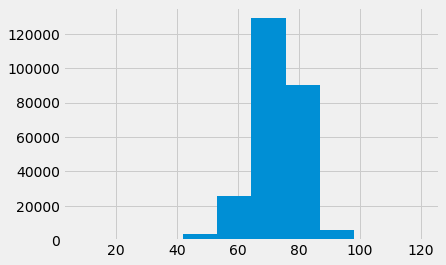

In [50]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_ADR'].hist()
plt.show()

In [53]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 'ADR']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(13751, 8)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR
0,8248,PACT,16847,mhL,10.382967,2.301226,20.153995,50.379149
2,7535,ROG SPUNJ,11789,Misfit,13.635393,1.994288,16.666406,63.325690
3,9791,ROG pronax,17082,Ex6poN,17.221979,3.268116,17.239530,70.496142
4,8695,ROG nooky,18457,s1las,15.812395,5.000000,17.654941,68.485427
5,7538,ROG fl0m,8503,fl0m,16.133416,4.517028,17.655834,70.443003


In [48]:
player_norm_df.loc[player_norm_df['true_ADR'] > 95, 'player_name'].unique()

array(['witmer', 'Itsumi', 'USTILO', 'x1ron', 'jemi', 'Puttzk',
       'juanflatroo', 'AdamJW', 'CAth', 'DalcoN', 'Maniac', 'SEN1K',
       'MEs', 'DeathMakeR', 'Tim[1]', 'zWin', 'clone', 'PALM1', 'vic',
       'NEY', 'Mal1ce', 'dyvo', 'allee', 'Sceebo', 'NnyQuil', 'yenKOGOD',
       'pnq', 'Nipa', 'JasmiN', 'PureR', 'low', 'Kanpeki', 'YouGod',
       'THE_BEST', 'blackie', 'YuRk0', 'Tusi', 'gfi', 'uW', 'Bulkymarko',
       'MEZi', 'Unknown1997', 'HSB', 'Remind', 'SiameseCv', 'xeL', 'dFx',
       'c2h', 'Nille', 'Keung', 'Raizy', 'eXPLOSION', 'Little_F', 'ricz',
       'nonono', 'disTroiT', 'Fatality', 'Puaka', 'ZM', 'FF', 'aum101',
       'kiLLeRa', 'fly772', 'ryanJ', 'sleiden', 'DEATHLESS', 't0m',
       'Pimp', 'Nira', 'Wrath', 'Mopsim', 'clackj', 'amnesia', 'charleS',
       'siz', 'mirari', 'NsDude', 'Blo3y', 'royalG', 'xelos', 'snaky',
       'dabliw', 'shijienimoge', 'fear', 'eason', 'Asils', 'AnjK',
       'Spitfire', 'Npoint', 'Skeis', 'Zedith'], dtype=object)

#### EDA

In [146]:
player_name = 'EliGE'

# Collect all data on player
player = player_df.loc[player_df['player_name'] == player_name, :]
print(player.shape)
player.head()

(407, 23)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
325,80290,mrg,2019-01-19,5973,Liquid,8738,EliGE,32,13,7,5,13,88.9,19,113.0,2,1.84,1.19,0.48,1.79,162.0,0.007195,0.000197
342,80308,cch,2019-01-20,5973,Liquid,8738,EliGE,29,14,7,0,10,90.9,19,133.4,1,2.07,1.32,0.45,2.20,161.0,0.007417,0.000204
349,80317,d2,2019-01-20,5973,Liquid,8738,EliGE,28,13,6,2,14,84.0,14,108.7,3,1.79,1.12,0.56,2.06,161.0,0.007417,0.000204
2341,82576,ovp,2019-03-11,5973,Liquid,8738,EliGE,16,9,3,1,17,70.8,-1,62.9,3,0.99,0.67,0.71,1.21,111.0,0.034014,0.000934
4150,84678,mrg,2019-04-18,5973,Liquid,8738,EliGE,27,15,2,0,8,84.2,19,121.1,4,2.06,1.42,0.42,2.37,73.0,0.108227,0.002971


In [147]:
player['normalized_decay'].sum()

0.9999999999999999

In [138]:
player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay
0,79922,inf,2019-01-04,8248,PACT,16847,mhL,18,9,1,0,16,63.0,2,74.5,4,1.14,0.67,0.59,1.41,177.0,0.411799
1,79923,mrg,2019-01-04,8248,PACT,16847,mhL,19,12,4,0,17,64.0,2,79.6,-2,1.08,0.76,0.68,1.05,177.0,0.411799
2,79924,d2,2019-01-04,7535,ROG SPUNJ,11789,Misfit,15,6,3,1,17,58.3,-2,70.1,0,0.94,0.62,0.71,0.99,177.0,0.411799
3,79925,mrg,2019-01-04,9791,ROG pronax,17082,Ex6poN,21,9,1,0,19,65.4,2,71.0,0,1.09,0.81,0.73,1.30,177.0,0.411799
4,79926,cch,2019-01-04,8695,ROG nooky,18457,s1las,20,11,5,0,20,79.2,0,91.4,1,1.17,0.83,0.83,1.10,177.0,0.411799


In [136]:
(1-0.001) ** 177

0.8377055948310873

### ESL ONE COLOGNE Bracket

<img src="../images/ESL One Cologne-Group A.png" class="center" style="width:500px;height:300px"> <img src="../images/ESL One Cologne-Group B.png" class="center" style="width:500px;height:300px">

<img src="../images/ESL One Cologne-Teams.png" class="center" style="width:600px;height:600px">

Top teams from each upper bracket advances to semi-finals. The losers of the upper bracket finals play in the quarterfinals. Top teams from each lower bracket advances to quarterfinals.